In [1]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import random
from decimal import Decimal
import heapq
import matplotlib.pyplot as plt 
import matplotlib
from Object import ConvertibleBondObject, AccountData

In [2]:
import os
os.chdir('../')

In [3]:
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman'] 

#### 1.数据导入

In [4]:
redemption = pd.read_excel("./Data/强制赎回统计.xlsx") # 强制赎回统计
redemption.loc[:,"OUT_STATUS"] = True

redemption_pivot = redemption.pivot(index = "ANN_DATE",columns = "S_INFO_WINDCODE",values = "OUT_STATUS")
redemption_pivot.index = pd.to_datetime(redemption_pivot.index)

In [5]:
close_price = pd.read_excel("./Data/收盘价.xlsx",index_col = 0)
open_price = pd.read_excel("./Data/开盘价.xlsx",index_col = 0)
avg_price = pd.read_excel("./Data/均价.xlsx",index_col = 0)

In [6]:
month_begin_end = pd.read_excel("./Data/月初月末表.xlsx")

In [7]:
# 导入评级、余额、转股溢价率、上市时间、到期时间、退市时间等
rankings = pd.read_excel("./Data/债项评级.xlsx",index_col = 0)
outstanding_balance = pd.read_excel("./Data/债券余额.xlsx",index_col = 0)
important_date = pd.read_excel("./Data/重要日期.xlsx",index_col = 0)
premium = pd.read_excel("./Data/转股溢价率.xlsx",index_col = 0)

#### 2.数据清洗

In [8]:
important_date.SETUP_DATE = pd.to_datetime(important_date.SETUP_DATE)
important_date.DELIST_DATE = pd.to_datetime(important_date.DELIST_DATE)

In [9]:
# 获取债券理论存续日期
for i in important_date.index:
    mature_date = f"{important_date.at[i,'SETUP_DATE'].year + important_date.at[i,'SETUP_TERM']}-{important_date.at[i,'SETUP_DATE'].month}-{important_date.at[i,'SETUP_DATE'].day}"
    important_date.loc[i,"MATURE_DATE"] = mature_date

In [10]:
filled_close_price = close_price.asfreq("D").ffill()
filled_open_price = open_price.asfreq("D").ffill()
filled_avg_price = avg_price.asfreq("D").ffill()

filled_rankings = rankings.asfreq("D").ffill()
filled_outstanding_balance = outstanding_balance.asfreq("D").ffill()
filled_premium = premium.asfreq("D").ffill()

In [11]:
# 剔除上市之前和最后一个交易日后的市场数据
for cb in important_date.index:
    setup_date = important_date.at[cb,"SETUP_DATE"]
    delist_date = important_date.at[cb,"DELIST_DATE"]
    for df in [filled_close_price,filled_open_price,filled_avg_price,filled_rankings,filled_outstanding_balance,filled_premium]:
        df.loc[:setup_date-pd.Timedelta(days = 1),cb] = np.nan # 头尾包含
        df.loc[delist_date+pd.Timedelta(days = 1):,cb] = np.nan

In [12]:
important_date.MATURE_DATE = pd.to_datetime(important_date.MATURE_DATE)

#### 3.计算双低值

In [13]:
double_low_info = filled_close_price + filled_premium

#### 4.获取剩余期限

In [14]:
begin_date = pd.to_datetime(filled_close_price.index[0])
end_date = pd.to_datetime(filled_close_price.index[-1])

In [15]:
backtest_date_range = pd.date_range(begin_date,end_date)

In [16]:
# 获取剩余期限
mature_date_info = pd.DataFrame(index = backtest_date_range,columns = filled_close_price.columns)

for i in mature_date_info.index:
    for j in mature_date_info.columns:
        if i >= important_date.at[j,"SETUP_DATE"] and i <= important_date.at[j,"MATURE_DATE"]:
            mature_date_info.at[i,j] = (important_date.at[j,"MATURE_DATE"] - i).days

#### 5.获取回测结果

In [17]:
'''paramaters'''
position_size:int = 15
outstanding_balance_threshold:float = 3.0
ranking_selected:list = ["AA","AA+","AAA-","AAA"]
maturity_threshold:int = 365

'''variables'''
capital:float = 300000.0
backtest_pnl_result:pd.DataFrame = pd.DataFrame(index = backtest_date_range,columns = ["NET_VALUE","PNL_RATIO_DAILY"])

In [18]:
backtest_account = AccountData(capital) # initial personal account

In [19]:
for ix,date in enumerate(backtest_date_range):
    """"""
    try:
        next_date = backtest_date_range[ix + 1]
    except IndexError:
        next_date = date + pd.Timedelta(days = 1)
    # 发布赎回的转债先加入delete_cb里面
    backtest_account.delete_cb.extend(redemption.query("ANN_DATE == '{}'".format(date)).S_INFO_WINDCODE.tolist())
    
    # 清除触发博弈条款的转债
    for to_redemption_cb in list(backtest_account.in_position_cb.keys()):
        try:
            if redemption_pivot.at[date,to_redemption_cb] == True:
                backtest_account.in_position_cb[to_redemption_cb].calculate_daily_result(
                    price = float(Decimal(filled_close_price.at[date,to_sell_cb]).quantize(Decimal('0.0000'))),
                )
                backtest_account.sell(
                    vt_symbol = to_redemption_cb,
                    sell_price = float(Decimal(backtest_account.in_position_cb[to_redemption_cb].price).quantize(Decimal('0.0000'))),
                    volume = backtest_account.in_position_cb[to_redemption_cb].volume,
                    status = 'dsell',
                )
                print(f"sell {to_redemption_cb} at {backtest_account.in_position_cb[to_redemption_cb].price} in {date}, pnl is {backtest_account.in_position_cb[to_redemption_cb].pnl_ratio_total}")
        except KeyError or IndexError:
            pass

    if date.day in [28,29,30,31] and next_date.month != date.month: # 月底
        # 获取双低值最低的转债
        in_pool_cb = double_low_info.loc[date,(filled_outstanding_balance.loc[date] > outstanding_balance_threshold) & \
                                         (filled_rankings.loc[date].isin(["AA","AA+","AAA-","AAA"])) & \
                                         (mature_date_info.loc[date] >= 365)].dropna().sort_values().index.tolist()
        # 已经在赎回列表里的转债就不加入了
        for i in set(backtest_account.delete_cb) & set(in_pool_cb):
            in_pool_cb.remove(i)
        in_pool_cb = in_pool_cb[:position_size]

        # 清仓
        for to_sell_cb in (set(backtest_account.in_position_cb.keys()) - set(in_pool_cb)):
            backtest_account.in_position_cb[to_sell_cb].calculate_daily_result(
                price = float(Decimal(filled_close_price.at[date,to_sell_cb]).quantize(Decimal('0.0000'))),
            )
            backtest_account.sell(
                vt_symbol = to_sell_cb,
                sell_price = float(Decimal(backtest_account.in_position_cb[to_sell_cb].price).quantize(Decimal('0.0000'))),
                volume = backtest_account.in_position_cb[to_sell_cb].volume,
                status = "sell",
            )
            print(f"sell {to_sell_cb} at {backtest_account.in_position_cb[to_sell_cb].price} in {date}, pnl is {backtest_account.in_position_cb[to_sell_cb].pnl_ratio_total}")
    
    elif pd.to_datetime(date) in month_begin_end.MONTH_START_TRADE.tolist():
        for to_position_cb in (set(in_pool_cb) - set(backtest_account.in_position_cb.keys())):
            if pd.isnull(float(Decimal(filled_avg_price.at[date,to_position_cb]).quantize(Decimal('0.0000')))):
                continue
            buy_price = float(Decimal(filled_avg_price.at[date,to_position_cb]).quantize(Decimal('0.0000')))
            backtest_account.buy(
                vt_symbol = to_position_cb,
                buy_price = buy_price,
                volume = np.floor((backtest_account.balance/position_size)/(buy_price*10))*10, # maximum buys
            )
            print(f"buy  {to_position_cb} at {float(Decimal(filled_avg_price.at[date,to_position_cb]).quantize(Decimal('0.0000')))} in {date}")
    else:
        for vt_symbol in backtest_account.in_position_cb.keys():
            backtest_account.in_position_cb[vt_symbol].calculate_daily_result(
                price = float(Decimal(filled_close_price.at[date,vt_symbol]).quantize(Decimal('0.0000'))),
            )
    
    # update account info
    backtest_account.calculate_daily_result()
    backtest_account.remove_sold_order()
    backtest_pnl_result.at[date,["NET_VALUE","PNL_RATIO_DAILY"]] = backtest_account.balance,backtest_account.pnl_ratio_daily

buy  113010.SH at 114.932 in 2017-01-03 00:00:00
buy  110033.SH at 115.3511 in 2017-01-03 00:00:00
buy  128013.SZ at 113.768 in 2017-01-03 00:00:00
buy  113009.SH at 116.377 in 2017-01-03 00:00:00
buy  128011.SZ at 128.1127 in 2017-01-03 00:00:00
buy  110035.SH at 125.5253 in 2017-01-03 00:00:00
buy  110034.SH at 123.8918 in 2017-01-03 00:00:00
buy  128009.SZ at 121.749 in 2017-01-03 00:00:00
buy  128010.SZ at 119.7966 in 2017-01-03 00:00:00
buy  110030.SH at 114.0662 in 2017-01-03 00:00:00
buy  128012.SZ at 108.0457 in 2017-01-03 00:00:00
buy  110031.SH at 108.8925 in 2017-01-03 00:00:00
buy  123001.SZ at 108.6322 in 2017-01-03 00:00:00
buy  110032.SH at 111.6712 in 2017-01-03 00:00:00
sell 110031.SH at 107.14 in 2017-02-28 00:00:00, pnl is -0.017076777253097752
buy  127003.SZ at 111.2078 in 2017-03-01 00:00:00
sell 123001.SZ at 105.39 in 2017-04-30 00:00:00, pnl is -0.030814847856203587
sell 128012.SZ at 102.69 in 2017-04-30 00:00:00, pnl is -0.05051832153049485
buy  113011.SH at 101

sell 113508.SH at 102.68 in 2018-09-30 00:00:00, pnl is 0.026133372454584913
sell 128033.SZ at 95.281 in 2018-09-30 00:00:00, pnl is -0.008258993568203254
sell 127007.SZ at 93.402 in 2018-09-30 00:00:00, pnl is -0.007134649915179869
sell 113505.SH at 89.64 in 2018-09-30 00:00:00, pnl is -0.14521327036181908
sell 113018.SH at 113.09 in 2018-09-30 00:00:00, pnl is 0.05172390241948488
sell 113017.SH at 90.72 in 2018-09-30 00:00:00, pnl is -0.10158449923252355
sell 113506.SH at 93.8 in 2018-09-30 00:00:00, pnl is -0.07773208483218497
buy  128042.SZ at 94.5909 in 2018-10-08 00:00:00
buy  123001.SZ at 93.5429 in 2018-10-08 00:00:00
buy  113509.SH at 97.9323 in 2018-10-08 00:00:00
buy  128021.SZ at 96.482 in 2018-10-08 00:00:00
buy  123015.SZ at 91.1155 in 2018-10-08 00:00:00
buy  128044.SZ at 94.1341 in 2018-10-08 00:00:00
buy  113016.SH at 96.0792 in 2018-10-08 00:00:00
sell 128042.SZ at 92.555 in 2018-10-31 00:00:00, pnl is -0.02250071135238718
sell 128038.SZ at 88.266 in 2018-10-31 00:00:

sell 113535.SH at 101.75 in 2019-09-30 00:00:00, pnl is 0.013646320432625592
sell 110052.SH at 123.3 in 2019-09-30 00:00:00, pnl is 0.006000576409774139
sell 123004.SZ at 101.417 in 2019-09-30 00:00:00, pnl is 0.007455651624301396
sell 128064.SZ at 101.8 in 2019-09-30 00:00:00, pnl is -0.0065420668734201826
sell 128060.SZ at 129.2 in 2019-09-30 00:00:00, pnl is 0.32200105569765425
sell 113016.SH at 99.78 in 2019-09-30 00:00:00, pnl is 0.010755668044888367
sell 110047.SH at 108.53 in 2019-09-30 00:00:00, pnl is -0.003534923363021303
buy  128071.SZ at 104.6618 in 2019-10-08 00:00:00
buy  113516.SH at 106.9246 in 2019-10-08 00:00:00
buy  128055.SZ at 117.9123 in 2019-10-08 00:00:00
buy  113530.SH at 104.5067 in 2019-10-08 00:00:00
buy  123009.SZ at 115.2232 in 2019-10-08 00:00:00
buy  128030.SZ at 121.0274 in 2019-10-08 00:00:00
buy  128048.SZ at 107.4898 in 2019-10-08 00:00:00
sell 127003.SZ at 105.08 in 2019-10-31 00:00:00, pnl is 0.015248059689753068
sell 128030.SZ at 169.0 in 2019-10-

sell 110052.SH at 108.3 in 2020-06-30 00:00:00, pnl is -0.046847989007015145
sell 128059.SZ at 132.99 in 2020-06-30 00:00:00, pnl is 0.055040558368303794
sell 127007.SZ at 109.55 in 2020-06-30 00:00:00, pnl is -0.05433355275010521
sell 123002.SZ at 116.004 in 2020-06-30 00:00:00, pnl is -0.08000920967850289
sell 128106.SZ at 124.55 in 2020-06-30 00:00:00, pnl is 0.027893428580422652
sell 113578.SH at 127.55 in 2020-06-30 00:00:00, pnl is 0.03340181520938046
buy  113033.SH at 102.0091 in 2020-07-01 00:00:00
buy  128087.SZ at 101.0915 in 2020-07-01 00:00:00
buy  110066.SH at 112.4538 in 2020-07-01 00:00:00
buy  128034.SZ at 103.8669 in 2020-07-01 00:00:00
buy  128097.SZ at 111.8652 in 2020-07-01 00:00:00
buy  128022.SZ at 107.473 in 2020-07-01 00:00:00
sell 110066.SH at 132.32 in 2020-07-31 00:00:00, pnl is 0.1754855077179447
sell 128034.SZ at 110.977 in 2020-07-31 00:00:00, pnl is 0.06738656748332605
sell 127003.SZ at 128.0 in 2020-07-31 00:00:00, pnl is 0.14624617010386487
sell 123048.

sell 113534.SH at 111.23 in 2021-05-31 00:00:00, pnl is 0.1348191503566889
sell 110072.SH at 92.5 in 2021-05-31 00:00:00, pnl is 0.05954026618867925
sell 128090.SZ at 109.995 in 2021-05-31 00:00:00, pnl is 0.012516872669259271
sell 110074.SH at 162.07 in 2021-05-31 00:00:00, pnl is 0.6220557693619291
sell 128140.SZ at 103.991 in 2021-05-31 00:00:00, pnl is 0.038852429527397314
buy  127033.SZ at 100.961 in 2021-06-01 00:00:00
buy  128106.SZ at 111.9556 in 2021-06-01 00:00:00
buy  128130.SZ at 117.7918 in 2021-06-01 00:00:00
buy  110080.SH at 104.867 in 2021-06-01 00:00:00
buy  128064.SZ at 112.6924 in 2021-06-01 00:00:00
sell 128087.SZ at 102.868 in 2021-06-30 00:00:00, pnl is 0.025074285823501796
sell 128106.SZ at 111.578 in 2021-06-30 00:00:00, pnl is -0.004368397234854937
sell 128064.SZ at 120.36 in 2021-06-30 00:00:00, pnl is 0.06697310767860354
sell 110057.SH at 112.01 in 2021-06-30 00:00:00, pnl is -0.013958131739702395
buy  113048.SH at 108.6303 in 2021-07-01 00:00:00
buy  128107

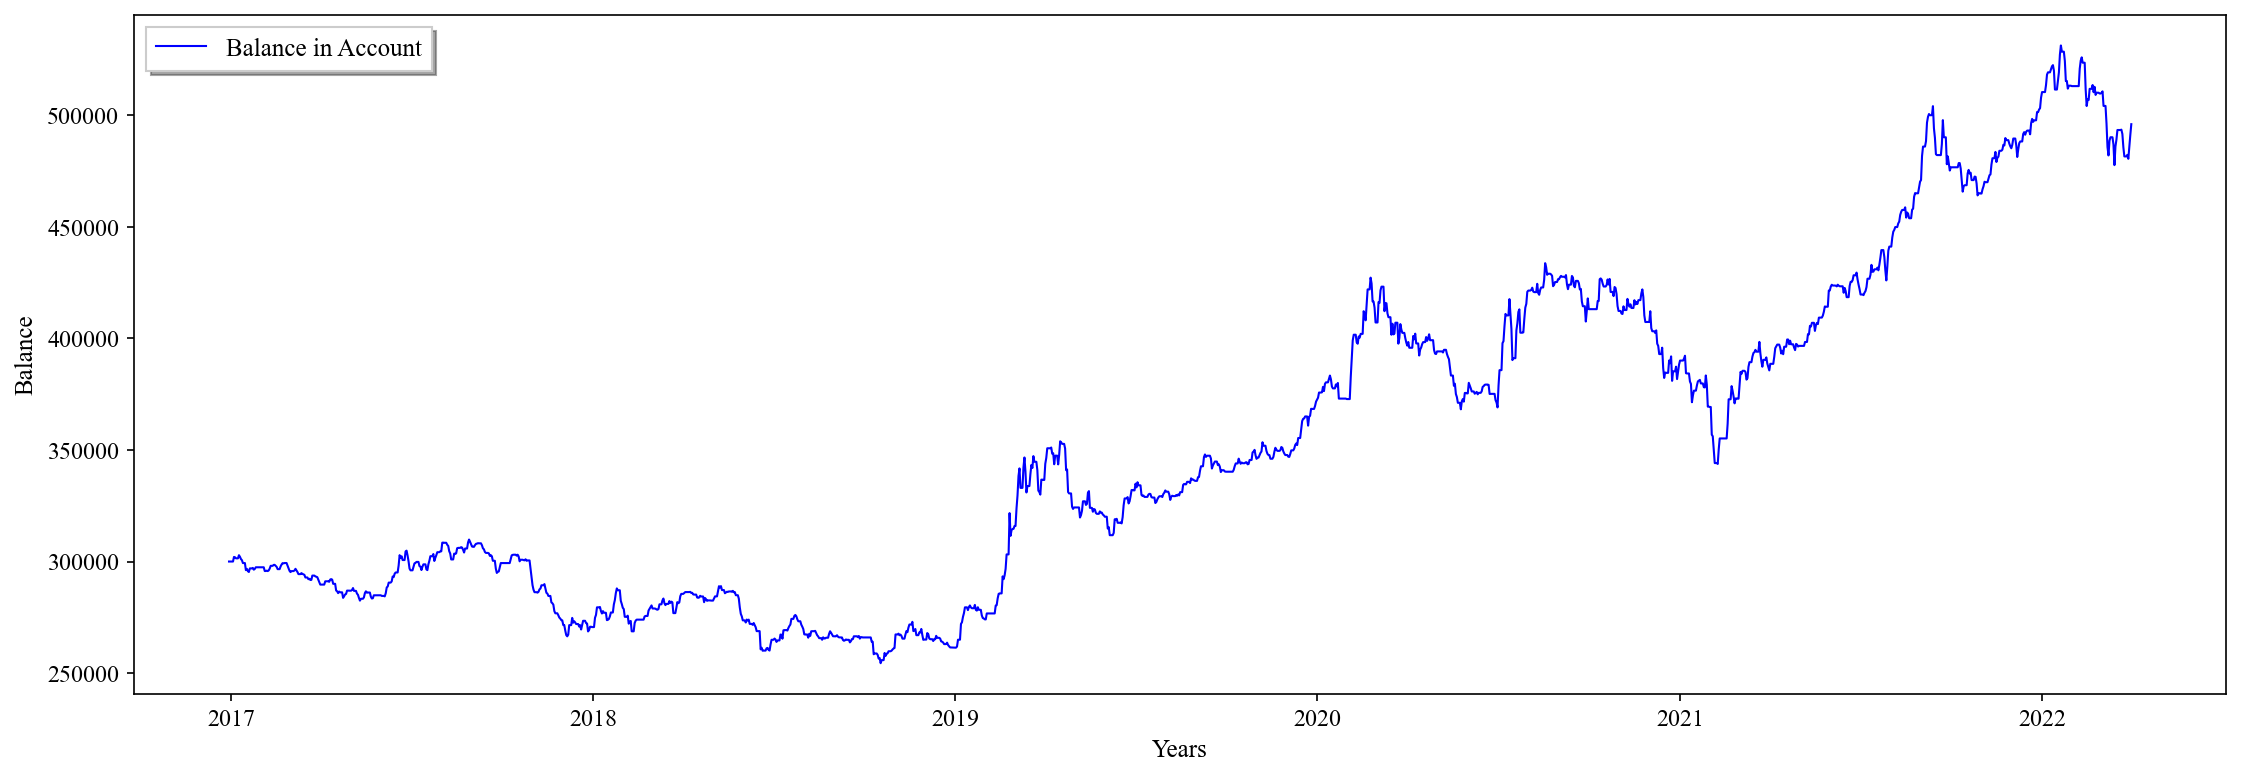

In [20]:
# plot
fig = plt.figure(figsize = (18,6),dpi = 150)
ax1 = fig.add_subplot(111)
ax1.plot(backtest_pnl_result.NET_VALUE, "-",color = "#0000FF",linewidth = 1,label = "Net Value")#非预测对比序列
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)
ax1.set_ylabel("Balance",fontsize = 12)
ax1.set_xlabel("Years",fontsize = 12)
ax1.legend(["Balance in Account"], loc = 'upper left',fontsize = 12,shadow = "gray",fancybox = False)